<a href="https://www.kaggle.com/code/inderjeet21/titanic-notebook?scriptVersionId=140301879" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Introduction

**My very first Kaggle notebook is here. After looking around the website, I chose to work on the Titanic dataset because it presents a manageable task for a beginning. I'm new to data science and machine learning, so any helpful criticism is appreciated!
The challenge revolves around predicting which passengers survived the Titanic shipwreck based on various passenger attributes such as name, age, gender, socio-economic class, etc.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 2. Load and explore data

In [2]:
#Reading in the train and test data
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

#Combining the train and test data into one dataframe 
combined = pd.concat([train_data, test_data])

In [3]:
#irst 5 rows of the combined dataframe
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#combined data 
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [5]:
print(f'Train data shape is {train_data.shape}')
print(f'Test data shape is {test_data.shape}')

Train data shape is (891, 12)
Test data shape is (418, 11)


There are 1309 observations, 12 variables, and 891 train observations and 418 test observations. By including the other factors as features in a machine learning model, we aim to predict the Survived variable.

### 3. Data Cleaning

In this section I will clean the data so it is ready to be used as input for a Machine Learning model.
1. Handle missing values
2. Encode categorical variables to numbers
3. Select features and target variable.

In [6]:
#Setting PassengerId to index
combined.set_index('PassengerId', inplace=True)

In [7]:
#A function which shows the number of null values for columns of a dataframe
def nulls(df):
    null = df.isna().sum()
    null = null[null>0].sort_values()
    return null
nulls(combined)

Fare           1
Embarked       2
Age          263
Survived     418
Cabin       1014
dtype: int64

In [8]:
#The cabin feature has the most missing values so I will deal with it first
#Observing the frequency of each type of cabin
combined.loc[:, 'Cabin'].value_counts()

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
F33                4
                  ..
A14                1
E63                1
E12                1
E38                1
C105               1
Name: Cabin, Length: 186, dtype: int64

It turns out that the first letter of the cabin variable indicates which deck of the Titanic the passengers cabin is in. I will replace the cabin values with the deck and then use One-Hot encoding later to create dummy variables for each type of deck which will deal with the high number of null values.

In [9]:
#Transforming cabin feature to only contain the first letter which is the deck
combined['Cabin'] = combined['Cabin'].str[0]

In [10]:
#Getting the index of the one null value for the Fare variable
Fare_missing_index = combined[combined.Fare.isna()].index[0]

#Looking at the observation which has a missing Fare value
combined.loc[Fare_missing_index]

Survived                   NaN
Pclass                       3
Name        Storey, Mr. Thomas
Sex                       male
Age                       60.5
SibSp                        0
Parch                        0
Ticket                    3701
Fare                       NaN
Cabin                      NaN
Embarked                     S
Name: 1044, dtype: object

In [11]:
#Filling this value using the mean of Fare for passengers with the same Pclass
#I will only use the train_data for the mean to prevent data leakage
Fare_mean = train_data[train_data.Pclass==3].Fare.mean().round(4)
combined.at[1044, 'Fare'] = Fare_mean

In [12]:
#Getting the index for the observations with Embarked as null
Embarked_missing_index = combined[combined.Embarked.isna()].index

#Looking at the observations which have missing values for Embarked
combined.loc[Embarked_missing_index]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B,NaN
830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B,NaN


In [13]:
#Looking at the freuqncy of each value Embarked can take
train_data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [14]:
#Filling this value using the mode value for Embarked
#I will only use the train_data for the mean to prevent data leakage
combined.at[Embarked_missing_index[0], 'Embarked'] = 'S'
combined.at[Embarked_missing_index[1], 'Embarked'] = 'S'

In [15]:
#Checking how many null values are left
nulls(combined)

Age          263
Survived     418
Cabin       1014
dtype: int64

In [16]:
#family_size is the number of family members each person has aboard the Titanic
#I add 1 to include each person in their own family
family_size = combined['SibSp'] + combined['Parch'] + 1

#Creating a new feature for the size of a person's family
#This feature uses 1-3 people as small(S), 4-6 people as Medium(M) and >6 as Large(L)
combined['Family_size'] = pd.cut(x=family_size,
                                 labels=['S', 'M', 'L'], bins=[0,3,6,11])
combined.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size
PassengerId,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,S
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,S


In [17]:
#Dropping the Ticket feature
combined.drop('Ticket', axis=1, inplace=True)

I will extract titles from the Name column to create a new feature called Title which can replace Name. I will do this using regular expressions (regex). This feature will only take values Mr,Mrs,Miss,Master.

In [18]:
titles = combined['Name'].str.extract(r',\s([a-zA-Z]+).')
titles.columns = ['Title']
titles['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the', 'Jonkheer',
       'Dona'], dtype=object)

In [19]:
#Checking the name which had a title of 'the'
combined[titles['Title']=='the'].Name

PassengerId
760    Rothes, the Countess. of (Lucy Noel Martha Dye...
Name: Name, dtype: object

In [20]:
# 'the' is not a valid title, title for this observation is meant to be 'Countess'
title_index = combined[titles['Title']=='the'].index[0]
titles.loc[title_index, 'Title'] = 'Countess'
titles['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [21]:
#Adding Title column to the combined dataframe and dropping the name column
combined = pd.concat([combined, titles], axis=1)
combined.drop('Name', axis=1, inplace=True)

In [22]:
#Dr could become Mr or Mrs but all other titles become one of the desired four
#Checking which people have Dr as their title
combined[combined['Title']=='Dr']

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_size,Title
PassengerId,,,,,,,,,,,
246,0.0,1,male,44.0,2,0,90.0000,C,Q,S,Dr
318,0.0,2,male,54.0,0,0,14.0000,NaN,S,S,Dr
399,0.0,2,male,23.0,0,0,10.5000,NaN,S,S,Dr
633,1.0,1,male,32.0,0,0,30.5000,B,C,S,Dr
661,1.0,1,male,50.0,2,0,133.6500,NaN,S,S,Dr
767,0.0,1,male,NaN,0,0,39.6000,NaN,C,S,Dr
797,1.0,1,female,49.0,0,0,25.9292,D,S,S,Dr
1185,NaN,1,male,53.0,1,1,81.8583,A,S,S,Dr


In [23]:
#Manually reassigning the female Dr title to Mrs
combined.at[797, 'Title'] = 'Mrs'
combined.loc[797]

Survived           1.0
Pclass               1
Sex             female
Age               49.0
SibSp                0
Parch                0
Fare           25.9292
Cabin                D
Embarked             S
Family_size          S
Title              Mrs
Name: 797, dtype: object

In [24]:
#Function for mapping each title to one of Mr, Mrs, Master, Miss
def title_mapper(df):
    if df in ['Mr', 'Don', 'Rev', 'Major', 'Sir', 'Col', 'Capt', 'Jonkheer', 'Dr']:
        return 'Mr'
    elif df in ['Mrs', 'Mme', 'Lady', 'Countess', 'Dona']:
        return 'Mrs'
    elif df in ['Miss', 'Ms', 'Mlle']:
        return 'Miss'
    elif df == 'Master':
        return 'Master'
    
#Mapping titles using the title_mapper function
combined['Title'] = combined['Title'].map(title_mapper)


In [25]:
#Now I will impute the missing values for Age using the median from its Title group
#I use train_data for the medians to prevent data leakage
Age_map = dict(combined.loc[:891, :].groupby('Title')['Age'].median().round(1))

def func(df):
    index = list(df[df.loc[:, 'Age'].isna()].index)
    titles = df.loc[index, 'Title']
    fill = list(titles.map(Age_map))
    for i in range(len(index)):
        df.at[index[i], 'Age'] = fill[i]

func(combined)

In [26]:
#Using One-Hot encoding to convert remaining categorical data to numerical data
combined_with_dummies = pd.get_dummies(combined)

In [27]:
combined_with_dummies.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,...,Embarked_C,Embarked_Q,Embarked_S,Family_size_S,Family_size_M,Family_size_L,Title_Master,Title_Miss,Title_Mr,Title_Mrs
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,22.0,1,0,7.2500,0,1,0,0,...,0,0,1,1,0,0,0,0,1,0
2,1.0,1,38.0,1,0,71.2833,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,1.0,3,26.0,0,0,7.9250,1,0,0,0,...,0,0,1,1,0,0,0,1,0,0
4,1.0,1,35.0,1,0,53.1000,1,0,0,0,...,0,0,1,1,0,0,0,0,0,1
5,0.0,3,35.0,0,0,8.0500,0,1,0,0,...,0,0,1,1,0,0,0,0,1,0


# 4. EDA

This section will explore some of the trends and relationships in the data. I will focus on the variables which have the highest correlation with Survived

In [28]:
#Looking at the correlation of features with the Survived column
#The largest correlations are with Title and Sex features
combined_with_dummies.corr()['Survived'].sort_values()

Title_Mr        -0.566512
Sex_male        -0.543351
Pclass          -0.338481
Embarked_S      -0.149683
Family_size_L   -0.078203
Age             -0.077786
SibSp           -0.035322
Cabin_T         -0.026456
Embarked_Q       0.003650
Family_size_M    0.014687
Cabin_G          0.016040
Cabin_A          0.022287
Family_size_S    0.029945
Cabin_F          0.057935
Parch            0.081629
Title_Master     0.085221
Cabin_C          0.114652
Cabin_E          0.145321
Cabin_D          0.150716
Embarked_C       0.168240
Cabin_B          0.175095
Fare             0.257307
Title_Miss       0.335636
Title_Mrs        0.350782
Sex_female       0.543351
Survived         1.000000
Name: Survived, dtype: float64

In [29]:
# Checking for number of survivors in train data
combined['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

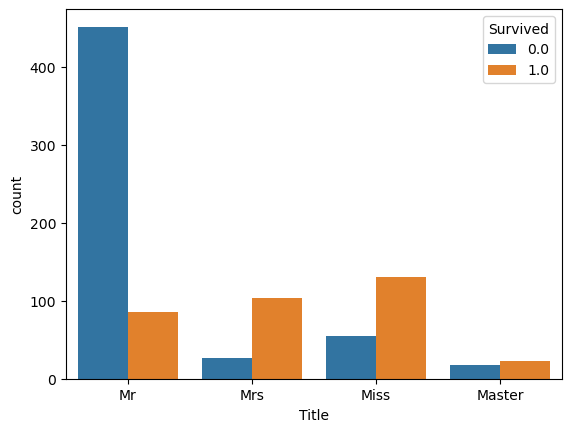

In [30]:
#Looking at survival for different sexes
#We can see most adult males die while most females and male children survive
sns.countplot(combined, x='Title', hue='Survived');

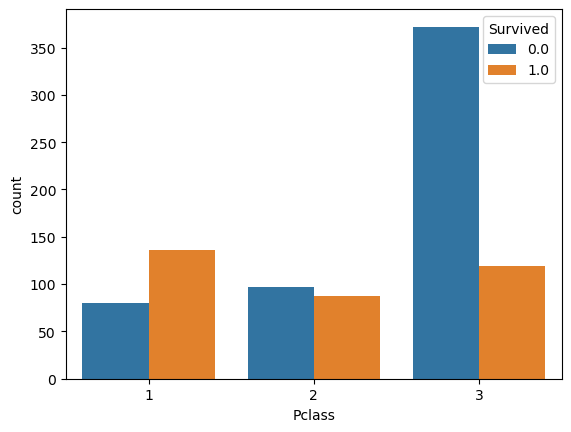

In [31]:
#Looking at survival for different Pclass
#We can see people with a higher Pclass are more likely to survive
sns.countplot(combined, x='Pclass', hue='Survived');

<Axes: xlabel='Fare', ylabel='Percent'>

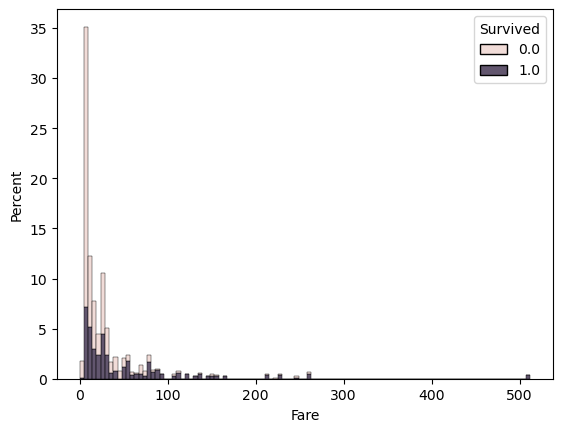

In [32]:
#Looking at distribution of Fare
#We see people who paid more are more likely to survive
sns.histplot(combined, x='Fare', hue='Survived', multiple='stack', stat='percent')

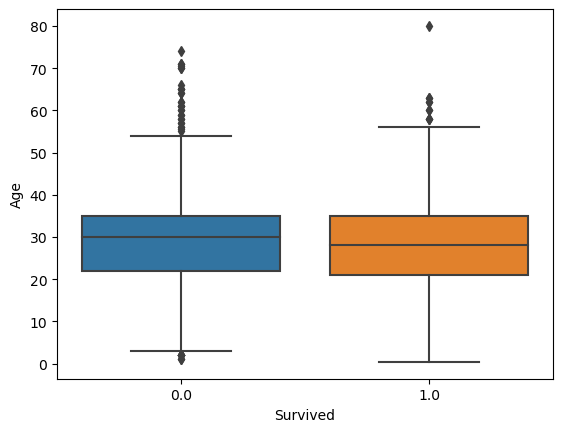

In [33]:
#Looking at age distribution for survivors and deaths
#Not much of a difference in distributions of ages of people who survived and those who don't
#Survivors have distribution with slightly lower age quantiles
sns.boxplot(combined, y='Age', x='Survived');

<Axes: >

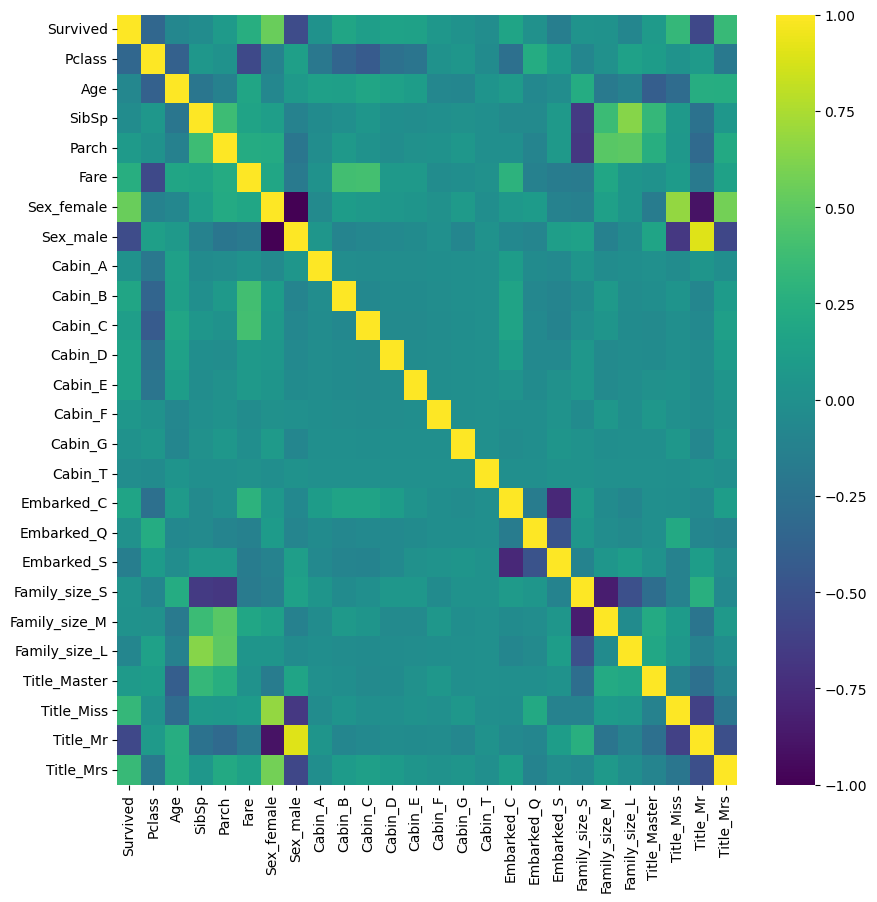

In [34]:
#Looking at the correlations between features
#Most correlations are low showing that features are adding different information
plt.figure(figsize=(10,10))
sns.heatmap(combined_with_dummies.corr(), cmap='viridis')

# 5. Model fitting and Predictions

Now I will fit a Machine Learning model to the training data. I perform hyperparameter tuning using GridSearchCV and then make predictions on the test data.

In [35]:
X_train = combined_with_dummies.loc[:891, :].drop('Survived', axis=1)
y_train = combined_with_dummies.loc[:891, 'Survived']
X_test = combined_with_dummies.loc[892:, :].drop('Survived', axis=1)

In [36]:
#Scale data before fitting a model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
#Fit model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators':[100, 125, 150], 'max_depth':[4, 5, 6]}
model = GridSearchCV(RandomForestClassifier(), params)
model.fit(X_train_scaled, y_train)

model.best_params_

{'max_depth': 5, 'n_estimators': 150}

In [38]:
#Best accuracy score during cross-validation with the best parameter settings
model.best_score_

0.8349883874207521

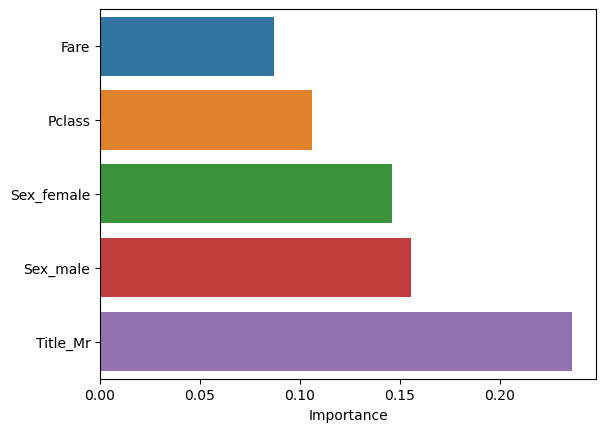

In [39]:
#Visualising the importance of each feature in the model
cols = X_train.columns
features = pd.DataFrame(data=model.best_estimator_.feature_importances_, 
                        index=cols, columns=['Importance']).sort_values(by='Importance')
features = features[features['Importance']>0.05]
sns.barplot(y=features.index, x=features['Importance']);

#The most important features show Age, social status and being a man have the greatest effect on survival

In [40]:
#Make predictions on test data
predictions = model.predict(X_test_scaled).astype(int)

In [41]:
#Making the submission
output = pd.DataFrame({'PassengerId': X_test.index, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
